# Machine Learning Stock Market Prediction Application

In [ ]:
!pip install yfinance
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#This application attempts to predict the stock price of the next day using the historical s&p index data. 
#It is good to note that for the stock market, it can be risky looking at very historical data; in other words, focus on more recent and relevant data
import yfinance as fin #obtains the stock market data from yahoo finance
sandp500 = fin.Ticker("^GSPC") #allows us to get price history for the s&p 500 index
sandp500 = sandp500.history(period = "max") #queries the the whole history (single trading day)
#removing unwanted sections of data
del sandp500["Stock Splits"]
del sandp500["Dividends"]
#removing too old historical data
sandp500 = sandp500.loc["1990-01-01":].copy() #removes all dates before 1990

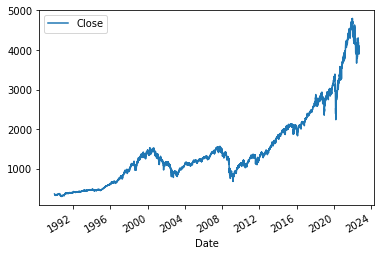

In [ ]:
sandp500.plot.line(y="Close", use_index=True) #Close = closing price

In [ ]:
sandp500["Next-Day"] = sandp500["Close"].shift(-1) #shifted prices back one day for Close and added a next day column
sandp500["Target"] = (sandp500["Close"] < sandp500["Next-Day"]).astype(int) #checks to see if tomorrow's price will be larger than today's price

# Create the model, training set, test set, predictors, and then train the model.

In [ ]:
from numpy import random
#training the model
from sklearn.ensemble import RandomForestClassifier #used to find non-linear relationships with the target price (stock prices tend to have non linear relationships)

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1) #the higher n_estimators is, the better the accuracy up to a limit; min_samples_split helps avoid overfitting (higher = lower accuracy); random_state when rerunning the model keeps previous guess accuracy
training_set = sandp500.iloc[:-100] #train the model with all data except the last 100
test_set = sandp500.iloc[-100:] #use the last 100 to test the model
column_predictors = ["Volume", "Close", "Low", "High", "Open"]
model.fit(training_set[column_predictors], training_set["Target"]) #actually trains the model using the predictor columns from the s&p data to predict the target

RandomForestClassifier(min_samples_split=100, random_state=1)

# Obtain the model's predictions and see the accuracy percentage

In [ ]:
#testing model accuracy
from sklearn.metrics import precision_score #helps check if the stock price truly went up (helps check the prediction accuracy)
import pandas

predictions = model.predict(test_set[column_predictors]) #places predictions in a numpy array
predictions = pandas.Series(predictions, index = test_set.index) #uses panda to convert numpy array to a more readable format
precision_score(test_set["Target"], predictions) #returns the accuracy percentage

0.5064935064935064

# Compare predictions vs actual values on a graph

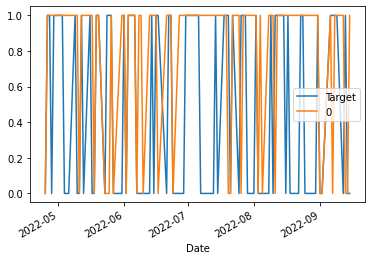

In [ ]:
#combining the predicted values with our actual values
pred_actual = pandas.concat([test_set["Target"], predictions], axis = 1)
pred_actual.plot() #0 --> predictions and Target --> actual values

# Implement backtesting to minimize error and obtain better accuracy. Place the prediction acquiring process within a function.

In [ ]:
#more robust way of testing the model via backtesting; gives better accuracy for each year
def backtest_model(model, given_data, preds, start = 2500, step = 250): #start --> take 10 years of data and train the model; step --> training the model for about a year; train with 10 years of data and predict the 11th year --> train with 11 years of data then predict the 12th year --> etc
  obtained_predictions = []
  for count in range(start, given_data.shape[0], step):
    test_set = given_data.iloc[count:(count + step)].copy()
    train_set = given_data.iloc[0:count].copy()
    predictions = get_predictions(model, train_set, test_set, preds)
    obtained_predictions.append(predictions)
  return pandas.concat(obtained_predictions)


#follows same steps as before, but in a function
def get_predictions(model, train_set, test_set, preds):
  model.fit(train_set[preds], train_set["Target"])
  predictions = model.predict(test_set[preds])
  predictions = pandas.Series(predictions, index = test_set.index, name="Predictions")
  pred_actual = pandas.concat([test_set["Target"], predictions], axis = 1)
  return pred_actual

In [ ]:
backtest_predictions = backtest_model(model, sandp500, column_predictors)

In [ ]:
backtest_predictions["Predictions"].value_counts() #gives the amount of days that the stock price increased and decreased

0    3301
1    2440
Name: Predictions, dtype: int64

In [ ]:
precision_score(backtest_predictions["Target"], backtest_predictions["Predictions"]) #accuracy percentage after backtest

0.5327868852459017

In [ ]:
backtest_predictions["Target"].value_counts() / backtest_predictions.shape[0] #gives percentages for when the stock price increased or decreased (the stock price increased 54% of days)

1    0.535969
0    0.464031
Name: Target, dtype: float64

# Use precise predictors that don't use absolute numbers to obtain better accuracy. Obtain the ratio and rolling average to compare today's market price with the market price from different days ago.

In [ ]:
#add more predictors to increase accuracy
days = [2, 5, 60, 250, 1000] # close price in the last [2 days, last trading week, last 3 months, last year, last 4 years]
#finding the ratio to determine if market has gone up a lot or down a lot; allows for the prediction of potential downfall or upward increase
additional_predictors = []

#checks current day's close price and the average in last 2, 5, 60, 250, and 1000 days
for span in days:
  average = sandp500.rolling(span)
  average = average.mean() #if there is not enough days to calculate average, NaN is outputted
  ratio = f"Close_Ratio_{span}" #add new column
  calculated_trend = f"Trend_{span}" #add new column
  sandp500[ratio] = sandp500["Close"] / average["Close"]
  #looks at the past few days and finds the total sum of the target (the days when the stock price went up)
  sandp500[calculated_trend] = sandp500.shift(1).rolling(span).sum()["Target"]
  additional_predictors = additional_predictors + [ratio, calculated_trend]

#since NaN is expected, remove them
sandp500 = sandp500.dropna()

# Make some small modifications to obtain more precise prediction values

In [ ]:
#checking how our model peforms with the new predictors
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1) #adjusting parameters this time around

#modified the prediction so it gives probability of getting 0 or 1 (better than just 0 or 1)
def get_predictions(model, train_set, test_set, preds):
  model.fit(train_set[preds], train_set["Target"])
  predictions = model.predict_proba(test_set[preds])[:,1] #get second column
  #reduces total num of trading days and increases the chance of the price actually going up; 60% is a perfect balance threshold
  #provides a more precise value for both
  predictions[predictions < 0.60] = 0
  predictions[predictions >= 0.60] = 1
  predictions = pandas.Series(predictions, index = test_set.index, name="Predictions")
  pred_actual = pandas.concat([test_set["Target"], predictions], axis = 1)
  return pred_actual

In [ ]:
#run the backtest again with modified model and prediction function
#using the new predictors because the previous ones were absolute numbers (doesn't help with predicting whether the stock price will go up or down; ratios work better (price today vs what it was yesterday or a few days ago))
backtest_predictions = backtest_model(model, sandp500, additional_predictors)

# The new model provides more precise and accurate predictions now

In [ ]:
#checking the predictions again
backtest_predictions["Predictions"].value_counts()

0.0    3935
1.0     805
Name: Predictions, dtype: int64

# The accuracy percentage has also increased. This is not a bad percentage given that it is only done with the S&P Prices and does not include many other relating factors.

In [ ]:
#checking the accuracy percentage again
#stock prices goes up about 57% of the time, not bad
precision_score(backtest_predictions["Target"], backtest_predictions["Predictions"])

0.5701863354037268